In [44]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Image Processing with Neural Network

## Template 05
## Working with PyTorch - Flowers DataSet

<img src='../../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [143]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd

from collections.abc import Callable
from typing import Literal


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from torchvision import datasets, transforms
from torchvision.transforms import v2

# from utils.helper import fn_plot_torch_hist

In [144]:
###----------------------
### Some basic parameters
###----------------------

inpDir = 'D:\DNN\input' # location where input data is stored
outDir = '../output' # location to store outputs                
modelDir = '../models'
subDir = 'flower_photos'
altName = 'cnn_base'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
torch.manual_seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 201 # number of epochs

BATCH_SIZE = 16

ALPHA = 0.001 # learning rate

TEST_SIZE = 0.2
TRAIN_SIZE=int(184*BATCH_SIZE) # 3670*0.8/16
# Input Image size
IMG_HEIGHT = 188
IMG_WIDTH = 188

# for early stopping 
PATIENCE = 20
LR_FACTOR = 0.1
LR_PATIENCE = 10

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
        #   'figure.figsize': (15, 10),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params)

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [145]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir, subDir)):
    os.makedirs(os.path.join(modelDir, subDir))
    print ('Created {} directory'.format(os.path.join(modelDir, subDir)))

## All about CUDA

In [146]:
# print ('Is CUDA available: ', torch.cuda.is_available())

# print ('CUDA version: ', torch.version.cuda )

# print ('Current Device ID: ', torch.cuda.current_device())

# print ('Name of the CUDA device: ', torch.cuda.get_device_name(torch.cuda.current_device()))

In [147]:
# Get cpu or gpu device for training.

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

Using cpu device


In [148]:
###------------------------------------------------
### Plot Loss Curve using Tensorflow history object
###------------------------------------------------
def fn_plot_tf_hist(hist_df):
    
    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    '''
        
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)
    
    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0] + offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()
    

In [149]:
###----------------------
### Plot confusion matrix
###----------------------
def fn_plot_confusion_matrix(y_true, y_pred, labels):

    cm  = confusion_matrix(y_true, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels.values())
    
    fig, ax = plt.subplots(figsize = (6,6))
    
    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
    # Disable the grid
    ax.grid(False)

    plt.show();


In [150]:
def fn_plot_label(tr_ds, ts_ds):
    
    plt.figure(figsize = (15,5)) # instantiate the figure
    
    plt.subplot(1,2,1) # first out of 2

    train_labels = tf.concat([lbl for img, lbl in tr_ds], axis = 0).numpy() # get the labels

    unique, _, counts = tf.unique_with_counts(train_labels) # get counts

    plt.bar(range(len(unique)), counts, align='center', color = 'DarkBlue') # barplot the counts

    plt.xticks(range(len(unique)), class_names)

    plt.title('Training Set')

    plt.subplot(1,2,2)
    
    test_labels = tf.concat([lbl for img, lbl in ts_ds], axis = 0).numpy()

    unique, _, counts = tf.unique_with_counts(test_labels)

    plt.bar(range(len(unique)), counts, align='center', color = 'Orange')

    plt.xticks(range(len(unique)), class_names)

    plt.title('Test Set')


## Read Flowers data set

In [151]:
###---------------
### Transformation
###---------------

# transform = transforms.Compose([
#     transforms.Resize(IMG_HEIGHT),
#     transforms.CenterCrop(IMG_HEIGHT),
#     transforms.ToTensor(),
#     transforms.Normalize( mean = [0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])  
# ])

transform = v2.Compose([
    v2.Resize(IMG_HEIGHT),
    v2.CenterCrop(IMG_HEIGHT),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

'''
    This is where we will add Data Augmentation
'''

data_dir = os.path.join(inpDir, subDir)

dataset = datasets.ImageFolder(data_dir, transform=transform)

In [152]:
torch.__version__

'2.3.0+cpu'

In [153]:
import torchvision
torchvision.__version__

'0.18.0+cpu'

In [154]:
image, label = next(iter(dataset))
image.shape, label

(torch.Size([3, 188, 188]), 0)

In [155]:
dataset_size = len(dataset)

test_size = int(TEST_SIZE*dataset_size) # 22*32

train_size = dataset_size - test_size
print (dataset_size, train_size, test_size)

3407 2726 681


In [156]:
indices = torch.randperm(len(dataset)).tolist()
#indices

# pick up indices up to test_size
train_dataset = torch.utils.data.Subset(dataset,indices[:-test_size])

# pickup from test_size
test_dataset = torch.utils.data.Subset(dataset,indices[-test_size:])

In [157]:
class_names = train_dataset.dataset.classes
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [158]:
numClasses = len(class_names)
numClasses

5

In [159]:
next(iter(train_dataset))[0].shape

torch.Size([3, 188, 188])

## Data Loader

In [160]:
#torch.utils.data.DataLoader?

In [161]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               shuffle= True)

test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                               batch_size=BATCH_SIZE,
                                               shuffle= True)


trainSteps = len(train_dataloader.dataset) // BATCH_SIZE

testSteps = len(test_dataloader.dataset) // BATCH_SIZE

print (trainSteps, testSteps)

170 42


In [162]:
def fn_showImages(img, ax):

    img = img.numpy().transpose((1,2,0))

    means = np.array([0.485, 0.456, 0.406])
    
    stds = np.array([0.229, 0.224, 0.225])
    
    img = stds * img + means
    
    img = np.clip(img, 0, 1)
    
    ax.imshow(img)
    ax.axis('off')

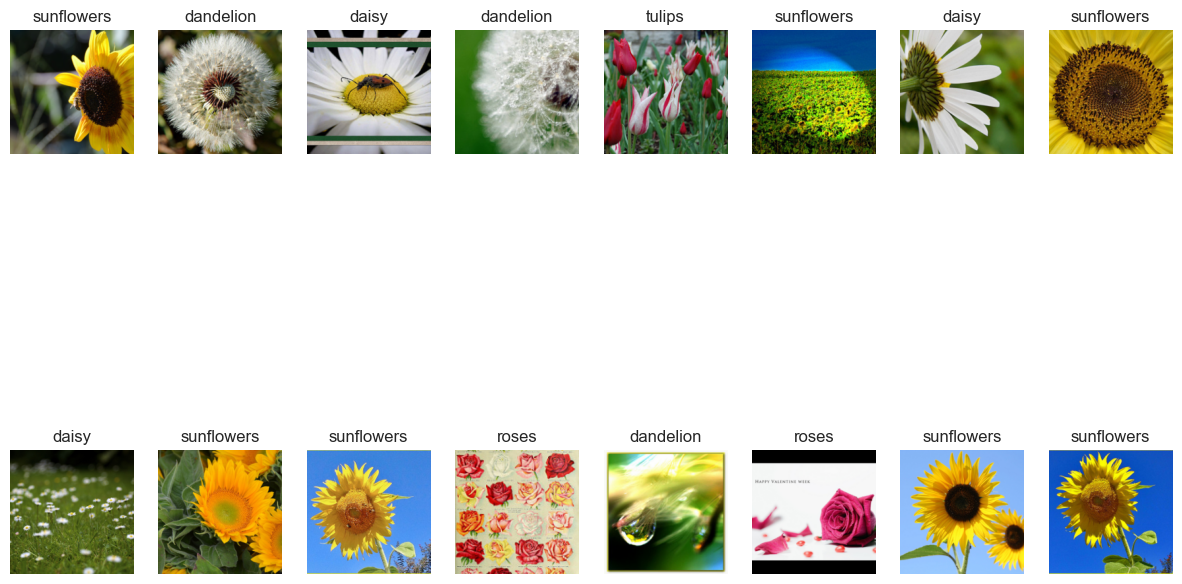

In [163]:
images, labels =next(iter(train_dataloader))

#print (images.shape, labels.shape)

fig = plt.figure()

for i in range (BATCH_SIZE):

    ax = fig.add_subplot(BATCH_SIZE//8, 8, i+1)
    
    fn_showImages(images[i], ax)

    ax.set_title(class_names[labels[i].numpy()])

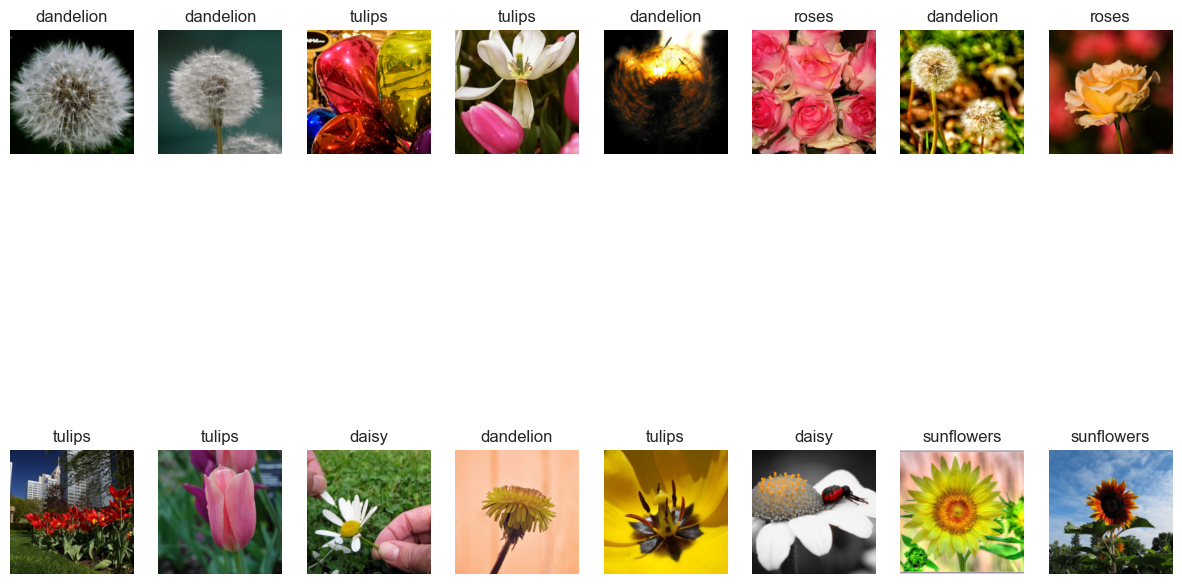

In [164]:
images, labels =next(iter(test_dataloader))

#print (images.shape, labels.shape)

fig = plt.figure()

for i in range (BATCH_SIZE):

    ax = fig.add_subplot(BATCH_SIZE//8, 8, i+1)
    
    fn_showImages(images[i], ax)

    ax.set_title(class_names[labels[i].numpy()])

In [165]:
class LeNet(nn.Module):

    def __init__(self, numChannels, classes) -> None:
        super(LeNet).__init__()

        dor1 = 0.3
        dor2 = 0.3
        dor3 = 0.4
        dor4 = 0.5
        dor5 = 0.5


        # Define Layers


        ## Set 1 ##
        out_channels1 = 128
        self.conv1 = nn.Conv2d(in_channels = numChannels,
                               out_channels  = out_channels1,
                               kernel_size=(3, 3))
        
        self.actv1 = nn.LeakyReLU()

        self.maxpool1 = nn.MaxPool2d(kernel_size=(4, 4),
                                     stride=(4, 4))
        
        self.dropout1 = nn.Dropout(p=dor1)

        ## Set 2 ##
        out_channels2 = 128

        self.conv2 = nn.Conv2d(in_channels=out_channels1,
                               out_channels=out_channels2,
                               kernel_size=(3, 3))
        self.bn2 = nn.BatchNorm2d(out_channels2)

        self.actv2 = nn.LeakyReLU()

        self.maxpool2 = nn.MaxPool2d(kernel_size=(4, 4),
                                     stride=(4, 4))
        
        self.dropout2 = nn.Dropout(p=dor2)


        ## Set 3 ##
        out_channels3 = 256

        self.conv2 = nn.Conv2d(in_channels=out_channels2,
                               out_channels=out_channels3,
                               kernel_size=(3, 3))
        self.bn2 = nn.BatchNorm2d(out_channels2)

        self.actv3 = nn.LeakyReLU()

        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2),
                                     stride=(2, 2))
        
        self.dropout3 = nn.Dropout(p=dor3)


        ## Set 4 ##
        out_channels4 = 512

        self.conv2 = nn.Conv2d(in_channels=out_channels3,
                               out_channels=out_channels4,
                               kernel_size=(3, 3))
        self.bn2 = nn.BatchNorm2d(out_channels2)

        self.actv4 = nn.LeakyReLU()

        self.maxpool4 = nn.MaxPool2d(kernel_size=(2, 2),
                                     stride=(2, 2))
        
        self.dropout4 = nn.Dropout(p=dor4)


        ## Head ##
        out_channels5 = 1024

        self.fc1 = nn.Linear(in_features=4*4* out_channels4,
                       out_features=out_channels5)
        
        self.bn5 = nn.BatchNorm1d(out_channels5)

        self.actv5 = nn.LeakyReLU()

        self.dropout5 = nn.Dropout(p=dor5)


        self.fc2 = nn.Linear(in_features=out_channels5,
                             out_features=classes)
        
        self.logSoftmax = nn.LogSoftmax(dim=1)

    def forword(self, x):

        # pass through 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.actv1(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)

        # pass through 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.actv2(x)
        x = self.maxpool2(x)
        x = self.dropout2(x)

        # pass through 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.actv3(x)
        x = self.maxpool3(x)
        x = self.dropout3(x)

        # pass through 4
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.actv4(x)
        x = self.maxpool4(x)
        x = self.dropout4(x)

        x = torch.flatten(x, 1)

        # Head fully connected layers
        x = self.fc5(x)
        x = self.bn5(x)
        x = self.actv5(x)
        x = self.dropout5(x)

        # output
        x = self.fc2
        return self.logSoftmax(x)

In [166]:
numChannels = 3
model = LeNet(numChannels=numChannels, classes=numClasses).to(device)

summary(model, {numChannels, IMG_HEIGHT, IMG_WIDTH})

AttributeError: cannot assign module before Module.__init__() call